# Motivation 
in this notebook, we will show how to use the PSD alteration method to generate virtual anomalies.


In [1]:
# database_path load from config file
from config import settings
from pathlib import Path
settings_proc ='SETTINGS1'
settings_simu = 'SETTINGS1'
root= Path(settings.data.path["processed"])
database_path = (root /settings_simu/settings_simu.lower()).with_suffix('.db')

In [2]:
import sqlite3
import numpy as np
conn = sqlite3.connect(database_path)
c = conn.cursor()
c.execute("SELECT * FROM metadata")
metadata = c.fetchone()
fs, nperseg, filter_order, lpf, freq, SNR = metadata
freq_axis = np.frombuffer(freq, dtype=np.float64)


In [3]:
len(freq_axis)

513

In [4]:
from psm.models.prepare_data import CreateTransformer
cr=CreateTransformer(database_path,freq_axis , 0, 150)
transform_psd = cr.transform_psd
label_transform = cr.label_transform


In [5]:
# load the data using the PSDDataset class 
from psm.models.prepare_data import PSDDataset

# load the data using the PSDDataset class
dataset = PSDDataset(
    database_path=database_path,

    anomaly_level=0,
    stage='test')



/home/yacine/Documents/PhD/Code/GitProject/PBSHM_mdof/psm/models/prepare_data.py:165: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  psd = torch.from_numpy(psd).float()


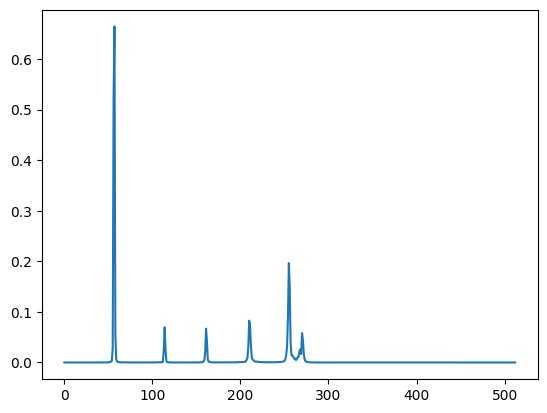

In [6]:
# grab a sample from the dataset
import matplotlib.pyplot as plt
sample = dataset[0]
plt.plot(sample[0])


In [7]:
fs

400.0

In [48]:
import torch
def construct_nodge(freq,f_oi,length,amp):
    freq_index = len(freq)/freq[-1]
    length = np.round(length*freq_index,0).astype('int')
    window  = np.ones(freq.shape)
    hann_len = np.sum(np.abs(freq-f_oi)<length)
    hann = 1-np.hanning(hann_len)*amp
    window[np.abs(freq-f_oi)<length] = hann
    return window
def multiply_signals_log(psd,window):


    log_psd = torch.log(psd)
    #  normalize the psd
    min_psd = torch.min(log_psd)
    max_psd = torch.max(log_psd)
    log_psd = (log_psd - min_psd) / (max_psd - min_psd)
    psd_aff =log_psd+(1-window)
    # then unnormalize the psd
    psd_aff = psd_aff * (max_psd - min_psd) + min_psd
    res = torch.exp(psd_aff)
    return res
def affect_psd(psd,freq,amp,f_oi,length):
    window = construct_nodge(freq=freq,f_oi=f_oi,length=length,amp=amp)
    psd_res = multiply_signals_log(psd,window)
    return psd_res


In [51]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt

# Define your application
app = dash.Dash(__name__)

# Your actual construct_nodge function and freq_axis, sample arrays go here

app.layout = html.Div([
    dcc.Graph(id='graph'),
    dcc.Slider(
        id='f_oi-slider',
        min=0,
        max=200,
        step=2,
        value=50,
        marks={},
        updatemode='drag'
    ),
    dcc.Slider(
        id='length-slider',
        min=0,
        max=10,
        step=1,
        value=1,
    ),
    dcc.Slider(
        id='amp_slider',
        min=-1,
        max=1,
        step=0.05,
        value=0.5,
    )
])

@app.callback(
    Output('graph', 'figure'),
    [Input('f_oi-slider', 'value'),
     Input('length-slider', 'value'),
     Input('amp_slider', 'value')]
)
def update_graph(f_oi, length, amp):
    anomaly_param = {'f_oi' : f_oi, 'length' : length, 'amp' : amp}
    window = construct_nodge(freq_axis,**anomaly_param)
    psd_res = affect_psd(psd,freq_axis,**anomaly_param)

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=freq_axis, y=window, mode='lines', name='notch filter', yaxis='y2'))
    fig.add_trace(go.Scatter(x=freq_axis, y=sample[0], mode='lines', name='original'))
    fig.add_trace(go.Scatter(x=freq_axis, y=psd_res, mode='lines', name='affected'))

    fig.update_layout(
        yaxis_type="log",
        yaxis2=dict(
            title="notch filter",
            titlefont=dict(
                color="red"
            ),
            tickfont=dict(
                color="red"
            ),
            overlaying="y",
            side="right",
            range=[0, 2]
        )
    )
    
    return fig


app.run_server(debug=True)
